# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import skimage
from skimage import transform
import datetime
import os
import cv2


We set the random seed so that the results don't vary drastically.

In [3]:
import seaborn as sns
from matplotlib import pyplot as plt
import tensorflow as tf
from keras import backend as K
import random as rn
np.random.seed(30)
rn.seed(30)
tf.set_random_seed(30)
%matplotlib inline


sns.set_style(style='dark')
sns.set_context("notebook")

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

Using TensorFlow backend.


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

# Change the base folder path accordingly

In [4]:
base_path = 'Project_data/'

In [5]:
train_doc = np.random.permutation(open(base_path + 'train.csv').readlines())
val_doc = np.random.permutation(open(base_path + 'val.csv').readlines())

In [6]:
def get_image(folder, index):
    image_name = os.listdir(folder)[index]
    image = skimage.io.imread(folder + "/" + image_name).astype(np.float32)
    return image

In [7]:
def resize_image(image,image_shape):
    return cv2.resize(image, image_shape, interpolation = cv2.INTER_AREA)

In [8]:
def crop(image):
    return image[0:120, 20:140]

In [9]:
def modify_image(image, image_shape):
    if (image.shape[0] == image.shape[1]):
        return resize_image(image, image_shape)
    else:
        return resize_image(crop(image), image_shape)

In [10]:
train_path = base_path + 'train'
val_path = base_path + 'val'

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [11]:

def get_batch_data(t, source_path, batch, batch_size, number_of_folders,
                   img_idx, image_shape):
    batch_data = np.zeros(
        (number_of_folders, len(img_idx), image_shape[0], image_shape[1], 3))
    # batch_labels is the one hot representation of the output
    batch_labels = np.zeros((number_of_folders, 5))
    for folder in range(number_of_folders):  # iterate over the batch_size
        # read all the images in the folder
        imgs = os.listdir(source_path + '/' +
                          t[folder + (batch * batch_size)].split(';')[0])
        # Iterate over the frames/images of a folder to read them in
        for idx, item in enumerate(img_idx):
            image = get_image(
                source_path + '/' +
                t[folder + (batch * batch_size)].strip().split(';')[0], item)

            # Here, we are croping and resizing the image based on its dimensions
            image = modify_image(image, image_shape)
            # normalize image
            image = image / 255
            # crop the images and resize them. Note that the images are of 2 different shape
            # and the conv3D will throw error if the inputs in a batch have different shapes
            # normalise and feed in the image
            batch_data[folder, idx, :, :, 0] = image[:, :, 0]
            # normalise and feed in the image
            batch_data[folder, idx, :, :, 1] = image[:, :, 1]
            # normalise and feed in the image
            batch_data[folder, idx, :, :, 2] = image[:, :, 2]
        current_class = int(t[folder +
                              (batch * batch_size)].strip().split(';')[2])
        batch_labels[folder, current_class] = 1
    return batch_data, batch_labels

In [12]:
def generator(source_path,
              folder_list,
              batch_size,
              list_of_frames,
              image_shape):
    print('Source path = ', source_path, '; batch size =', batch_size)
    # create a list of image numbers you want to use for a particular video
    img_idx = list_of_frames
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t) // batch_size  # calculate the number of batches
        for batch in range(
                num_batches):  # we iterate over the number of batches
            yield get_batch_data(t, source_path, batch, batch_size, batch_size,
                                 img_idx, image_shape)

        remaining_folder = len(t) % batch_size
        if remaining_folder > 0:
            yield get_batch_data(t, source_path, num_batches, batch_size,
                                 remaining_folder, img_idx, image_shape)


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

## Parameters

In [13]:
curr_dt_time = datetime.datetime.now()
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30
print('# epochs =', num_epochs)
batch_size = 20
print('# batch size =', batch_size)
learning_rate = 0.002
print('# learnig rate =', learning_rate)
image_shape = (120, 120)
print('# image shape =', image_shape)
list_of_frames = list(range(0,30))
print('# list of frames =', list_of_frames)
activation = 'relu'
print('# activation =', activation)

# training sequences = 663
# validation sequences = 100
# epochs = 30
# batch size = 20
# learnig rate = 0.002
# image shape = (120, 120)
# list of frames = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
# activation = relu


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [14]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.regularizers import l2
# write your model here

model = Sequential()

model.add(
    Conv3D(8,
           kernel_size=(3, 3, 3),
           input_shape=(len(list_of_frames), image_shape[0], image_shape[1],
                        3),
           padding='same'))
model.add(BatchNormalization())
model.add(Activation(activation))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(16, kernel_size=(3, 3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation(activation))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation(activation))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation(activation))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256, kernel_regularizer=l2(0.01)))
model.add(Activation(activation))
model.add(Dropout(0.5))

model.add(Dense(128))
model.add(Activation(activation))
model.add(Dropout(0.5))

model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [15]:
optimiser = optimizers.Adam(lr=learning_rate)
model.compile(optimizer=optimiser,
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 60, 60, 16)    64        
_________________________________________________________________
activation_2 (Activation)    (None, 15, 60, 60, 16)    0         
__________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [16]:
train_generator = generator(train_path, train_doc, batch_size, list_of_frames,
                            image_shape)
val_generator = generator(val_path, val_doc, batch_size, list_of_frames,
                          image_shape)

In [17]:
model_name = 'model_init' + '_' + \
    str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + \
    'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=False,
                             save_weights_only=False,
                             mode='auto',
                             period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2,
                       verbose=1)  # write the REducelronplateau code here
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)
callbacks_list = [checkpoint, LR, es]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [18]:
if (num_train_sequences % batch_size) == 0:
    steps_per_epoch = int(num_train_sequences / batch_size)
else:
    steps_per_epoch = (num_train_sequences // batch_size) + 1

if (num_val_sequences % batch_size) == 0:
    validation_steps = int(num_val_sequences / batch_size)
else:
    validation_steps = (num_val_sequences // batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

Source path =  Project_data/val ; batch size = 20
Source path =  Project_data/train ; batch size = 20
Epoch 1/30
34/34 [==============================] - 180s 5s/step - loss: 8.4728 - categorical_accuracy: 0.2149 - val_loss: 5.5070 - val_categorical_accuracy: 0.1900

Epoch 00001: saving model to model_init_2020-09-1416_21_58.024867/model-00001-8.54479-0.22021-5.50704-0.19000.h5
Epoch 2/30
34/34 [==============================] - 59s 2s/step - loss: 4.8053 - categorical_accuracy: 0.3024 - val_loss: 4.1252 - val_categorical_accuracy: 0.4300

Epoch 00002: saving model to model_init_2020-09-1416_21_58.024867/model-00002-4.82013-0.30166-4.12523-0.43000.h5
Epoch 3/30
34/34 [==============================] - 61s 2s/step - loss: 3.7501 - categorical_accuracy: 0.3679 - val_loss: 3.8136 - val_categorical_accuracy: 0.3800

Epoch 00003: saving model to model_init_2020-09-1416_21_58.024867/model-00003-3.73822-0.37707-3.81355-0.38000.h5
Epoch 4/30
34/34 [==============================] - 64s 2s/step

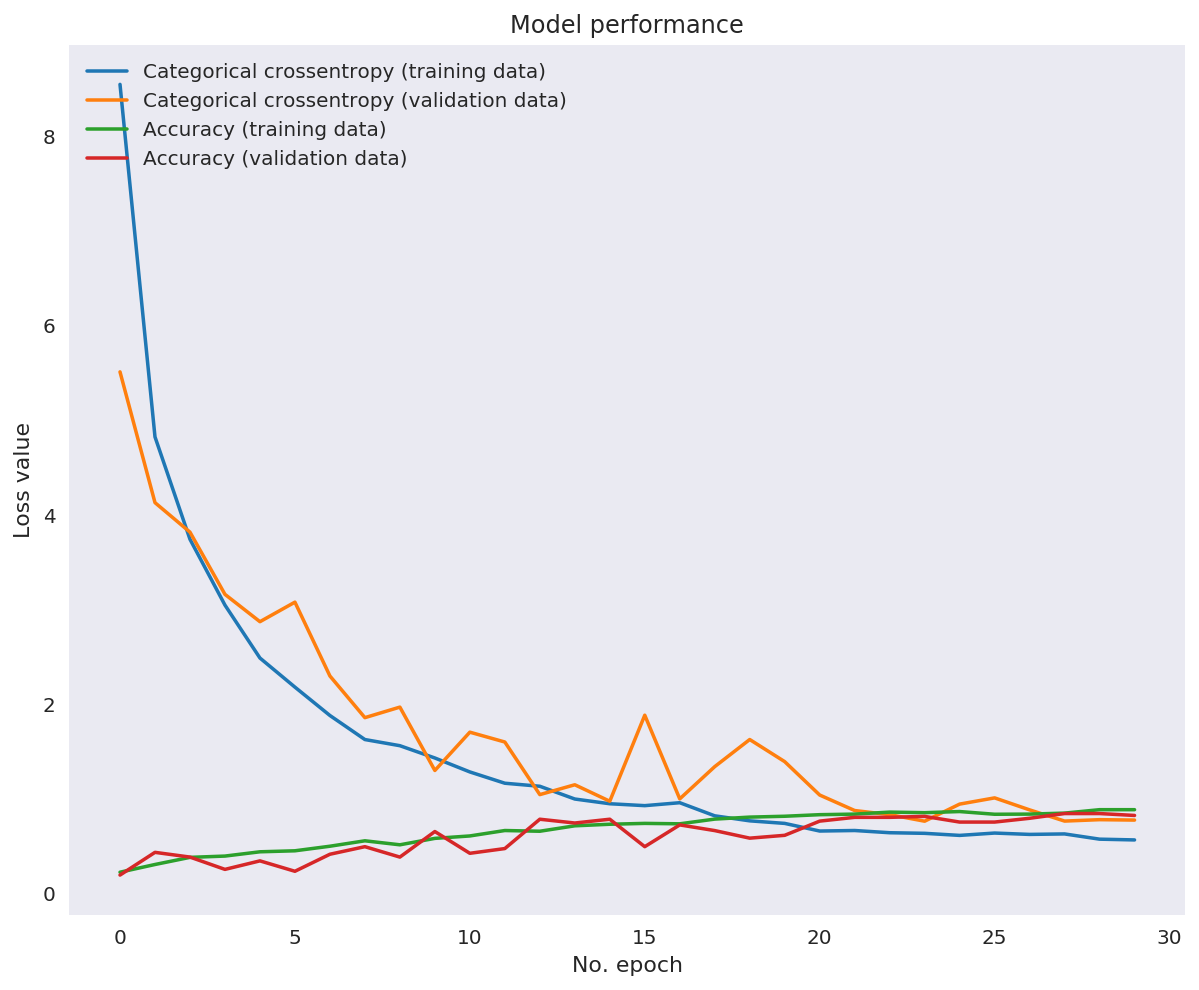

In [19]:
history = model.fit_generator(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=num_epochs,
                    verbose=1,
                    callbacks=callbacks_list,
                    validation_data=val_generator,
                    validation_steps=validation_steps,
                    class_weight=None,
                    workers=1,
                    initial_epoch=0)

fig = plt.figure(figsize=(10, 8))
plt.plot(history.history['loss'],
         label='Categorical crossentropy (training data)')
plt.plot(history.history['val_loss'],
         label='Categorical crossentropy (validation data)')
plt.plot(history.history['categorical_accuracy'],
         label='Accuracy (training data)')
plt.plot(history.history['val_categorical_accuracy'],
         label='Accuracy (validation data)')

plt.title('Model performance')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()